%%latex
\tableofcontents

# Template

In [33]:
from os.path import join
from pathlib import Path
from pandas import read_csv
from json import load, loads
from requests import get

In [34]:
with open(join("config", "manifest.json"), 'r') as config:
    config = load(config)

path = join(*config["output"])

In [35]:
# [ASSIGN] the sample metadata used to conduct the analysis to a reference variable
SAMPLES = read_csv(join("input", "samples.csv"))

# [ASSIGN] the genomic location metadata used to conduct the analysis to a reference variable
LOCATIONS = read_csv(join("input", "locations.csv"))

# [ASSIGN] the dataset metadata used to conduct the analysis to a reference variable
DATASETS = read_csv(join("input", "datasets.csv"))

In [36]:
# [ASSIGN] all unique populations found in our sample annotations
POPULATIONS_TO_COMPARE = SAMPLES["super-population"].unique().tolist()

In [37]:
# [ASSIGN] the columns that form the multiindex
MULTIINDEX = ["CHROM", "POS", "REF", "ALT"]

In [38]:
DATA = dict()

_total = 0

# [FOR] each gene in our list of gene regions included in this analysis...
for gene in LOCATIONS["location_name"].unique().tolist():

    # [ASSIGN] our data to a key within the DATA dictionary
    DATA[gene] = read_csv(
        join(
            path,
            "consolidated_reports",
            f"super-population_{gene}.csv",
        ),
        sep="\t"
    )
    DATA[gene].set_index("query", inplace=True)
    print(f"Record count | {gene} : {DATA[gene].shape[0]}")
    _total += DATA[gene].shape[0]
print(f"Total record count | {gene} : {_total}")
    

Record count | CYP2B6 : 1967
Record count | CYP2C9 : 2885
Record count | CYP2C19 : 6081
Record count | CYP2D6 : 435
Record count | CYP4F2 : 983
Record count | VKORC1 : 187
Record count | HLA-A : 614
Record count | HLA-B : 6980
Total record count | HLA-B : 20132


In [39]:
VEP_QUERY_RESULTS = dict()

# [FOR] each gene in our list of gene regions included in this analysis...
for gene in LOCATIONS["location_name"].unique().tolist():

    # [ASSIGN] our data to a key within the DATA dictionary
    VEP_QUERY_RESULTS[gene] = read_csv(join(
            path,
            "tmp",
            "super-population",
            gene,
            "variant_effect_predictions.csv"
            ))
    VEP_QUERY_RESULTS[gene].set_index("query", inplace=True)

In [40]:
def extractGnomADFrequencies(vep_result: dict, population: str, allele: str):
    if "colocated_variants" not in vep_result:
        return None
    colocated_variants = loads(vep_result)["colocated_variants"]
    variant_frequencies = next((variant["frequencies"][allele] for variant in colocated_variants if "frequencies" in variant and allele in variant["frequencies"]), None)
    if variant_frequencies is None:
        return None
    # selected_record = next([record for record in variant_frequencies if allele in record["frequencies"]], None)
    if any(key == f"gnomadg_{population.lower()}" for key, _ in variant_frequencies.items()):
        result = variant_frequencies[f"gnomadg_{population.lower()}"]
        return result
    else:
        return None

In [41]:
server = "https://rest.ensembl.org"
ext = "/variation/human/"
def retriveGnomADFrequency(query: str):
    formatted_query =server+ext+query+"?content-type=application/json;pops=1"
    print(formatted_query)
    result = get(formatted_query)
    print(result)
    print(result.reason)

In [42]:
display(DATA[gene].keys().tolist())

['CHROM',
 'POS',
 'ID',
 'REF',
 'ALT',
 'QUAL',
 'FILTER',
 'Feature_type',
 'Consequence_type',
 'Biotype',
 'REVEL_score',
 'CADD',
 'CADD_PHRED',
 'SIFT_4G_score',
 'SIFT_4G_prediction',
 'SIFT_score',
 'SIFT_prediction',
 'PolyPhen_score',
 'PolyPhen_prediction',
 'Gene_symbol',
 'Gene_symbol_source',
 'Impact',
 'HGVSC',
 'Gene_ID',
 'Transcript_ID',
 'Exon',
 'isCanonical',
 'Variant_allele',
 'mutfunc_mod_dG_mt',
 'mutfunc_mod_ddG_sd',
 'mutfunc_mod_dG_wt',
 'mutfunc_mod_dG_mt_sd',
 'mutfunc_mod_dG_wt_sd',
 'mutfunc_mod_ddG',
 'mutfunc_exp_dG_mt',
 'mutfunc_exp_ddG_sd',
 'mutfunc_exp_dG_wt',
 'mutfunc_exp_dG_mt_sd',
 'mutfunc_exp_dG_wt_sd',
 'mutfunc_exp_ddG',
 'mutfunc_int_dG_mt',
 'mutfunc_int_ddG_sd',
 'mutfunc_int_dG_wt',
 'mutfunc_int_dG_mt_sd',
 'mutfunc_int_dG_wt_sd',
 'mutfunc_int_ddG',
 'mutfunc_motif_dG_mt',
 'mutfunc_motif_ddG_sd',
 'mutfunc_motif_dG_wt',
 'mutfunc_motif_dG_mt_sd',
 'mutfunc_motif_dG_wt_sd',
 'mutfunc_motif_ddG',
 'UTRAnnotator_5UTR_consequence',
 '

In [43]:
VEP_QUERY_RESULTS[gene]

,CHROM,POS,ID,REF,ALT,result
query,,,,,,
6:31269498-31269498:1/A,6,31269498,rs41559915;rs115583167,G,A,"{""input"": ""6:31269498-31269498:1/A"", ""transcri..."
6:31269524-31269524:1/C,6,31269524,.,A,C,"{""most_severe_consequence"": ""splice_region_var..."
6:31269528-31269528:1/A,6,31269528,rs1433597888,G,A,"{""most_severe_consequence"": ""splice_region_var..."
6:31269577-31269577:1/A,6,31269577,rs9264601;rs116571842,G,A,"{""assembly_name"": ""GRCh38"", ""variant_class"": ""..."
6:31269580-31269580:1/T,6,31269580,rs72558162,C,T,"{""start"": 31269580, ""most_severe_consequence"":..."
...,...,...,...,...,...,...
6:31357162-31357162:1/C,6,31357162,rs190427310,G,C,"{""allele_string"": ""G/C"", ""start"": 31357162, ""v..."
6:31357164-31357164:1/T,6,31357164,rs114038515,C,T,"{""transcript_consequences"": [{""gene_symbol"": ""..."
6:31357170-31357170:1/G,6,31357170,rs1330011808,A,G,"{""input"": ""6:31357170-31357170:1/G"", ""id"": ""6:..."


In [44]:

# [FOR] each gene in our list of gene regions included in this analysis...
for gene in LOCATIONS["location_name"].unique().tolist():
    for population in POPULATIONS_TO_COMPARE:

        # [ASSIGN] our data to a key within the DATA dictionary
        # DATA[gene][f"GnomAD_DB_{population}"] = 
        DATA[gene][f"GnomAD_Freq_{population}"] = DATA[gene].apply(lambda row: extractGnomADFrequencies(VEP_QUERY_RESULTS[gene].loc[row.name, "result"], population, row["ALT"]), axis=1)
        # DATA[gene].apply(lambda row: retriveGnomADFrequency(row["HGVSC"]), axis=1)

/tmp/ipykernel_19010/1659307492.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DATA[gene][f"GnomAD_Freq_{population}"] = DATA[gene].apply(lambda row: extractGnomADFrequencies(VEP_QUERY_RESULTS[gene].loc[row.name, "result"], population, row["ALT"]), axis=1)
/tmp/ipykernel_19010/1659307492.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  DATA[gene][f"GnomAD_Freq_{population}"] = DATA[gene].apply(lambda row: extractGnomADFrequencies(VEP_QUERY_RESULTS[gene].loc[row.name, "result"], population, row["ALT"]), axis=1)
/tmp/ipyke

In [65]:
DATA[gene]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,Feature_type,Consequence_type,Biotype,...,SAS_hypothesis_rejection,AFR_P_SAS_corrected,GnomAD_Freq_AFR,GnomAD_Freq_EUR,GnomAD_Freq_EAS,GnomAD_Freq_AMR,GnomAD_Freq_SAS,GnomAD_Freq_CSA,GnomAD_Freq_OCE,GnomAD_Freq_UAE
query,,,,,,,,,,,,,,,,,,,,,
6:31269498-31269498:1/A,6,31269498,rs41559915;rs115583167,G,A,191,PASS,Transcript,missense_variant,Protein coding,...,False,1.000000e+00,0.177900,None,0.028050,0.050050,0.239300,None,None,None
6:31269524-31269524:1/C,6,31269524,.,A,C,.,PASS,Transcript,splice_region_variant,Protein coding,...,False,1.000000e+00,NaN,None,NaN,NaN,NaN,None,None,None
6:31269528-31269528:1/A,6,31269528,rs1433597888,G,A,.,PASS,Transcript,splice_region_variant,Protein coding,...,False,1.000000e+00,0.000000,None,0.000000,0.000000,0.000000,None,None,None
6:31269577-31269577:1/A,6,31269577,rs9264601;rs116571842,G,A,115,PASS,Transcript,intron_variant,Protein coding,...,True,3.779008e-07,0.000243,None,0.000000,0.000354,0.000000,None,None,None
6:31269580-31269580:1/T,6,31269580,rs72558162,C,T,.,PASS,Transcript,intron_variant,Protein coding,...,False,1.000000e+00,0.000000,None,0.000000,0.000000,0.008055,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6:31357162-31357162:1/C,6,31357162,rs190427310,G,C,.,PASS,Transcript,5_prime_UTR_variant,Protein coding,...,False,1.000000e+00,0.001539,None,0.000000,0.087670,0.000000,None,None,None
6:31357164-31357164:1/T,6,31357164,rs114038515,C,T,.,PASS,Transcript,5_prime_UTR_variant,Protein coding,...,True,8.207824e-03,0.002495,None,0.061730,0.007426,0.016390,None,None,None
6:31357170-31357170:1/G,6,31357170,rs1330011808,A,G,.,PASS,Transcript,5_prime_UTR_variant,Protein coding,...,False,1.000000e+00,0.000244,None,0.000000,0.000000,0.000000,None,None,None


In [70]:
from pandas import melt
TMP = melt(DATA[gene], id_vars=["CHROM", "ID", "POS", "REF", "ALT"], value_vars=[f"GnomAD_Freq_{population}" for population in POPULATIONS_TO_COMPARE], value_name="Frequency", var_name="Population")
TMP

,CHROM,ID,POS,REF,ALT,Population,Frequency
0,6,rs41559915;rs115583167,31269498,G,A,GnomAD_Freq_AFR,0.1779
1,6,.,31269524,A,C,GnomAD_Freq_AFR,NaN
2,6,rs1433597888,31269528,G,A,GnomAD_Freq_AFR,0.0
3,6,rs9264601;rs116571842,31269577,G,A,GnomAD_Freq_AFR,0.000243
4,6,rs72558162,31269580,C,T,GnomAD_Freq_AFR,0.0
...,...,...,...,...,...,...,...
55835,6,rs190427310,31357162,G,C,GnomAD_Freq_UAE,None
55836,6,rs114038515,31357164,C,T,GnomAD_Freq_UAE,None
55837,6,rs1330011808,31357170,A,G,GnomAD_Freq_UAE,None
55838,6,rs34437781,31357178,C,T,GnomAD_Freq_UAE,None


In [ ]:
from seaborn import lineplot, scatterplot, regplot, FacetGrid

for gene in LOCATIONS["location_name"].unique().tolist():
    for population in POPULATIONS_TO_COMPARE:
        FacetGrid(data=DATA[gene], x=f"GnomAD_Freq_{population}", y=f"{population}")

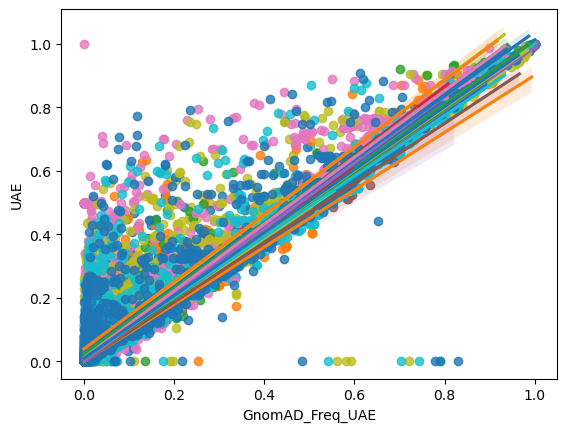

In [55]:
from seaborn import lineplot, scatterplot, regplot

for gene in LOCATIONS["location_name"].unique().tolist():
    for population in POPULATIONS_TO_COMPARE:
        regplot(data=DATA[gene], x=f"GnomAD_Freq_{population}", y=f"{population}")

In [47]:
# [CHECK] if directory exists, and create if it does not
Path(join(path, "Graphs", "01")).mkdir(exist_ok=True, parents = True)

In [48]:
for gene in LOCATIONS["location_name"].unique().tolist():
    for graph in PLOT[gene].keys(): 
        PLOT[gene][graph].write_image(join(path, "Graphs", "01", f"{gene}_{graph}.jpeg"))

# for gene in LOCATIONS["location_name"].unique().tolist():
#     PLOT[gene]["Variant Filters"].write_image(join(path, "Graphs", "01", "allele_abundance.jpeg"))

NameError: name 'PLOT' is not defined